## 多腕バンディット問題 (Multi-armed bandit problem)

source : これからの機械学習（森北出版）

---

### 問題設定
腕がK本あるスロットマシンを考える。  
払い戻される額をR、腕i (i = 1, 2, ..., K)を引いた場合のあたりが出る確率をpkとする。  
また、スロットマシンの状態は試行中に変化しないものとする。  
  
確率値pkが既知であれば、プレイヤーの最適な戦略は最大のR*pkを与える腕kを選び続けることである。  
しかしpkが未知であるとき、どのように腕を選べば払戻額を最大化することができるだろうか。  

In [1]:
# スロットマシンのプログラム
import numpy as np


class slotmachine(object):
    def __init__(self, 
                 reward_price=500, 
                 coin_price=100, 
                 distribution=(0.2, 0.3, 0.4, 0.5)):

        # 各スロットマシンの報酬Rとあたりが出る確率pkを定義する
        self.distributions = {}
        for i in range(len(distribution)):
            self.distributions[i] = (reward_price, distribution[i])
        self.reward_price = reward_price
        self.coin_price = coin_price
    
    def action_space(self):
        return len(self.distributions)
    
    def reward_space(self):
        return (self.reward_price, 0)

    def play(self, action):
        (R, p) = self.distributions[action]
        hit = np.random.choice([0, 1], 1, p=[1-p, p])[0]
        reward = R * hit - self.coin_price
        return reward, int(hit)

In [62]:
# ランダムに１０回引いてみる
m = slotmachine()
money = 1000
action_space_size = m.action_space()
print("選択肢の数 =",  action_space_size)

for i in range(10):
    action = np.random.choice(range(action_space_size))
    reward, hit = m.play(action)
    money += reward
    hit_message = "hit!" if hit==1 else "miss"
    print("action = {0}, {1}, money = {2}".format(action, hit_message, money))

選択肢の数 = 4
action = 1, miss, money = 900
action = 3, miss, money = 800
action = 2, miss, money = 700
action = 1, hit!, money = 1100
action = 1, miss, money = 1000
action = 0, hit!, money = 1400
action = 0, hit!, money = 1800
action = 1, hit!, money = 2200
action = 1, miss, money = 2100
action = 3, hit!, money = 2500


---

### greedyアルゴリズム
Algorithm
>まだn回選んだことがない腕がある場合、その腕を選ぶ  
>それ以外の場合、すべての腕に対して、これまでの報酬の平均を計算する  
>　　　　vi = (これまで腕iから得られた報酬の和) / (これまで腕iをプレイした回数)  
>viが最大の腕を選ぶ  

In [48]:
a = {
    0:[1, [3, 3, 1.], 1],
    1:[1, [2, 4, 2.], 1]
    }
#max_vv = max(a[:][2])
max_vv = max(a[x][1] for x in a)
print(max_vv)
#self.expected_reward[x][2] for x in self.expected_reward


# あとで消す
#max_key = max(a, key=(lambda x:a[x][1]))
#max_val = max(a[x][1] for x in a)
#key = [key for key in a if a[key][0]==max_val]

print(max_key, max_val)

[3, 3, 1.0]
6 50


In [55]:
def dic_a(a=None):
    if a is None:
        print("none")
    elif a == {}:
        print("dic")
    else:
        print("a")

dic_a({})

a = {}
for i in range(4):
    a[i] = [0, 0., 0.]
print(a)

max_val = max(a[x][2] for x in a)
print(max_val)

dic
{0: [0, 0.0, 0.0], 1: [0, 0.0, 0.0], 2: [0, 0.0, 0.0], 3: [0, 0.0, 0.0]}
0.0


In [57]:
class Agent_greedy(object):
    def __init__(self, action_space_size, min_choose=1, initial_play_count=0, expected_reward=None):
        self.action_space_size = action_space_size
        self.play_count = initial_play_count
        self.min_choose = min_choose
        
        # expected_reward[action_number] = (selected_count, sum of rewards, avarage of rewards)
        if expected_reward is None or expected_reward=={}:
            self.expected_reward = {}
            for i in range(action_space_size):
                self.expected_reward[i] = [0, 0., 0.]
        else:
            self.expected_reward = expected_reward
            
    def act(self):
        keys_of_less_selected = [key for key in self.expected_reward if self.expected_reward[key][0] < self.min_choose]
        if len(keys_of_less_selected)!=0:
            action = int(np.random.choice(keys_of_less_selected, 1))
            return action
        else:
            max_val = max(self.expected_reward[x][2] for x in self.expected_reward)
            keys_of_max_expected = [key for key in self.expected_reward if self.expected_reward[key][2] == max_val]
            action = int(np.random.choice(keys_of_max_expected))
            return action
        
    def update(self, action, reward):
        self.play_count += 1
        self.expected_reward[action][0] += 1
        self.expected_reward[action][1] += reward
        self.expected_reward[action][2] = self.expected_reward[action][1] / self.expected_reward[action][0]

    def load_record(self, initial_play_count, expected_reward):
        self.play_count = initial_play_count
        if expected_reward is None or expected_reward=={}:
            self.expected_reward = {}
            for i in range(action_space_size):
                self.expected_reward[i] = [0, 0., 0.]
        else:
            self.expected_reward = expected_reward
        
    def save_record(self):
        return self.play_count, self.expected_reward

    def reset_record(self):
        self.play_count = 0
        self.expected_reward = {}
        for i in range(action_space_size):
            self.expected_reward[i] = [0, 0., 0.]
    
    def sum_reward(self):
        sum_reward = 0
        for value in self.expected_reward.values():
            sum_reward += value[1]
        return sum_reward
    
    def action_count(self):
        action_count = []
        for value in self.expected_reward.values():
            action_count.append(value[0])
        return action_count
        

In [24]:
# 動作例
m = slotmachine()
money = 0
action_space_size = m.action_space()

agent = Agent_greedy(action_space_size, min_choose=3)

for i in range(1000):
    action = agent.act()
    reward, hit = m.play(action)
    agent.update(action, reward)
    money += reward
    #hit_message = "hit!" if hit==1 else "miss"
    #print("action = {0}, {1}, money = {2}".format(action, hit_message, money))
    if (i+1)%100==0:
        print("try:{0}, money={1}".format(i+1, money))

try:100, money=15000
try:200, money=33500
try:300, money=48500
try:400, money=64500
try:500, money=78000
try:600, money=95000
try:700, money=110500
try:800, money=123000
try:900, money=141000
try:1000, money=153000


このアルゴリズムは、  
・最適ではない腕i'の報酬の期待値Rpi'を、最適な腕iの期待値Rpiよりも大きいと誤認したとき、  
　試行回数を増加すればいつかは訂正できる  
  
しかし、  
・最適な腕iの報酬の期待値Rpiが他のある腕i'の期待値Rpi'よりも小さいと誤認したとき、  
　試行回数をいくら増加させても訂正できるとは限らない  
という問題がある。
  
このリスクを前言させ、探索コストを減らす手法の一つとして、  
下記のε-greedyアルゴリズムが知られている。  

### ε-greedyアルゴリズム
Algorithm
>まだ選んだことがない腕がある場合、その腕から一つ選ぶ  
>確率εで、すべての腕からランダムに一つ選ぶ  
>確率1-εで、これまでの報酬の平均viが最大の腕を選ぶ  

In [86]:
class Agent_e_greedy(Agent_greedy):
    def __init__(self, action_space_size, epsilon=0.1, min_choose=1):
        super(Agent_e_greedy, self).__init__(action_space_size, min_choose)
        self.epsilon = epsilon

    def act_greedy(self):
        keys_of_less_selected = [key for key in self.expected_reward if self.expected_reward[key][0] < self.min_choose]
        if len(keys_of_less_selected)!=0:
            action = int(np.random.choice(keys_of_less_selected, 1))
            return action
        else:
            max_val = max(self.expected_reward[x][2] for x in self.expected_reward)
            keys_of_max_expected = [key for key in self.expected_reward if self.expected_reward[key][2] == max_val]
            action = int(np.random.choice(keys_of_max_expected))
            return action    
        
    def act(self):
        if np.random.choice([1, 0], p=[self.epsilon, 1-self.epsilon]):
            action = int(np.random.choice(range(action_space_size)))
        else:
            action = self.act_greedy()
        return action
    

探索と利用のトレードオフを解く方法として  
「不確かなときは楽観的に (optimism in face of uncertainty)」という原理が知られている。  
  
この原理を用いた多腕バンディット問題の解放として、  
Upper Confidence Bound (UCB) アルゴリズムが有名である。  

### UCB1アルゴリズム
Algorithm  
>R : 払戻額の最大値と最小値の差  
>まだ選んだことのない腕があれば、そのうちの一つを選ぶ  
>各々の腕iから得られる報酬の期待値を計算する。  
>　　　　vi = (これまで腕iから得られた報酬の和) / (これまで腕iを選んだ回数)  
>各々の腕iから得られる報酬の信頼区間の半幅を計算する  
>　　　　Ui = R * root( (2ln(これまでの総プレイ回数)) / (これまで腕iをプレイした回数) )  
>vi + Ui が最大の腕iを選ぶ  

In [62]:
from math import sqrt, log

class Agent_ucb1(object):
    def __init__(self, action_space_size, reward_space=(500,0), min_choose=1,
                 initial_play_count = 0, expected_reward=None):
        self.action_space_size = action_space_size
        self.play_count = initial_play_count
        self.min_choose = min_choose
        self.reward_width = abs(reward_space[0] - reward_space[1])
        
        # expected_reward[action_number] = (selected_count, sum of rewards, 
        #                                   avarage of rewards, 1/2 * Confidence interval of reward,
        #                                   average + 1/2*CI)
        if expected_reward is None or expected_reward=={}:
            self.expected_reward = {}
            for i in range(action_space_size):
                self.expected_reward[i] = [0, 0., 0., 0., 0.]
        else:
            self.expected_reward = expected_reward

    def act(self):
        keys_of_less_selected = [key for key in self.expected_reward if self.expected_reward[key][0] < self.min_choose]
        if len(keys_of_less_selected)!=0:
            action = int(np.random.choice(keys_of_less_selected, 1))
            return action
        else:
            max_val = max(self.expected_reward[x][4] for x in self.expected_reward)
            keys_of_max_expected = [key for key in self.expected_reward if self.expected_reward[key][4] == max_val]
            action = int(np.random.choice(keys_of_max_expected))
            return action
        
    def update(self, action, reward):
        self.play_count += 1
        self.expected_reward[action][0] += 1
        self.expected_reward[action][1] += reward
        self.expected_reward[action][2] = self.expected_reward[action][1] / self.expected_reward[action][0]
        self.expected_reward[action][3] = self.reward_width * sqrt((2*log(self.play_count)) / (self.expected_reward[action][0]))
        self.expected_reward[action][4] = self.expected_reward[action][2] + self.expected_reward[action][3]
    
    def load_record(self, initial_play_count, expected_reward):
        self.play_count = initial_play_count
        if expected_reward is None or expected_reward=={}:
            self.expected_reward = {}
            for i in range(action_space_size):
                self.expected_reward[i] = [0, 0., 0., 0., 0.]
        else:
            self.expected_reward = expected_reward
    
    def save_record(self):
        return self.play_count, self.expected_reward
    
    def reset_record(self):
        self.play_count = 0
        self.expected_reward = {}
        for i in range(action_space_size):
            self.expected_reward[i] = [0, 0., 0., 0., 0.]
        
    def sum_reward(self):
        sum_reward = 0
        for value in self.expected_reward.values():
            sum_reward += value[1]
        return sum_reward
    
    def action_count(self):
        action_count = []
        for value in self.expected_reward.values():
            action_count.append(value[0])
        return action_count

---

### 性能比較
参考文献の設定に従い、K=4の場合のシミュレーションを行う。  
４つの腕の払戻額は同じ（１とする）で、払戻率はそれぞれ0.2, 0.3, 0.4, 0.5である。  
学習は１エポックあたり1,000回、これを独立に1,000エポック繰り返し、結果を平均する。  

total_record len, len[action 1] =  1000 4
total_record len, len[action 1] =  1000 4
total_record len, len[action 1] =  1000 4

slot machine's settings: 
  arm,  chance of hit, color on glaph
    0        0.2        red
    1        0.3        yellow
    2        0.4        green
    3        0.5        blue



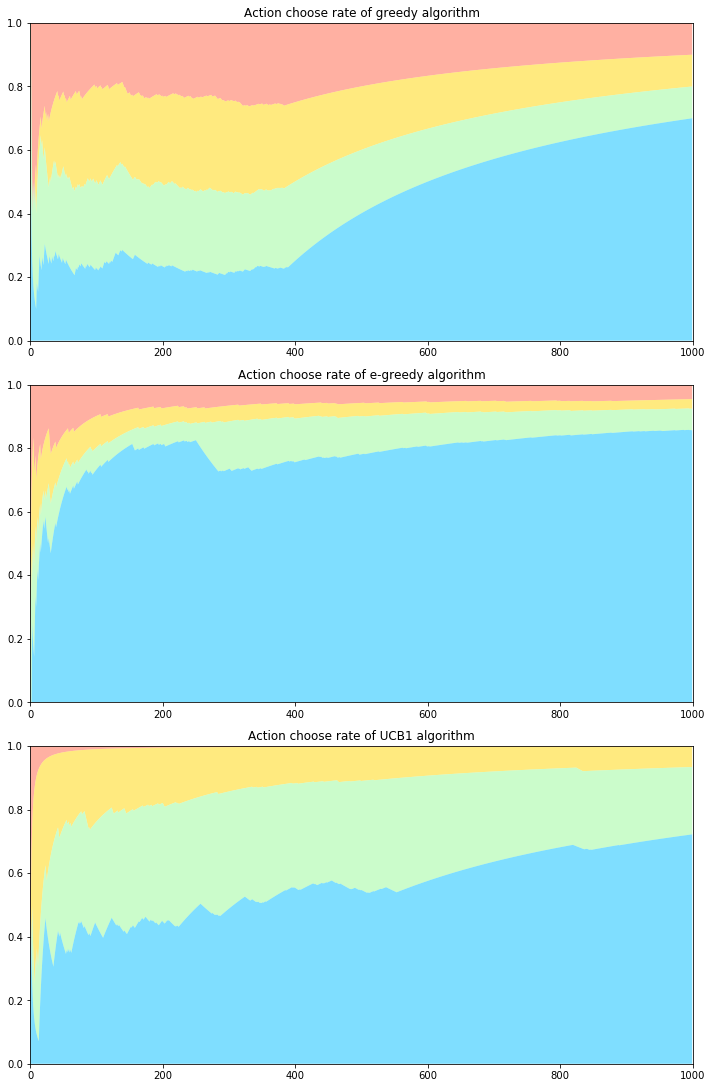

In [96]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

m = slotmachine(reward_price=1,
                coin_price=0, 
                distribution=(0.2, 0.3, 0.4, 0.5))
action_space_size = m.action_space()
reward_space_size = m.reward_space()

initial_play_count = 0
expected_reward = {}

agent_greed = Agent_greedy(action_space_size, min_choose=100)
agent_e_greed = Agent_e_greedy(action_space_size, epsilon=0.1, min_choose=1)
agent_ucb1 = Agent_ucb1(action_space_size, reward_space=reward_space_size, min_choose=1)

# 100 for debag
trial_num = 1000
epoch_num = 100

# for debug
reset_per_epoch = True

def exam_block(agent, trial_num=trial_num, reset_per_epoch=False,
               initial_play_count=0, expected_reward=None):
    # record[trial] = [trial, [each action's selected_count list], sum of reward]
    record = []
    agent.reset_record()
    if reset_per_epoch==False:
        agent.load_record(initial_play_count, expected_reward)
    
    for trial in range(trial_num):
        action = agent.act()
        reward, hit = m.play(action)
        agent.update(action, reward)
        record.append([trial, agent.action_count(), agent.sum_reward()])
    
    save_data = agent.save_record()
    
    return record, save_data
    
def epoch_block(agent, epoch_num=epoch_num, trial_num=trial_num, reset_per_epoch=False,
                initial_play_count=0, expected_reward=None):
    # total_record[trial] = [trial, [each action's total selected_count], total reward]
    record = []
    total_record = []
    
    play_count = 0
    expected_reward = {}
    save_data = (play_count, expected_reward)
    
    for epoch in range(epoch_num):
        record,save_data = exam_block(agent, trial_num=trial_num,
                                                          reset_per_epoch=reset_per_epoch,
                                                          initial_play_count=save_data[0],
                                                          expected_reward=save_data[1])
        if len(total_record)==0:
            total_record = record
        else:
            for trial in range(trial_num):
                if reset_per_epoch:
                    for action in range(action_space_size):
                        total_record[trial][1][action] = record[trial][1][action]
                    total_record[trial][2] = record[trial][2]
                else:
                    for action in range(action_space_size):
                        total_record[trial][1][action] += record[trial][1][action]
                    total_record[trial][2] += record[trial][2]

    return total_record
    

total_record_greed = epoch_block(agent_greed, epoch_num, trial_num, reset_per_epoch)
total_record_e_greed = epoch_block(agent_e_greed, epoch_num, trial_num, reset_per_epoch)
total_record_ucb1 = epoch_block(agent_ucb1, epoch_num, trial_num, reset_per_epoch)

# for debug
#print(" --- debug message ---")
#print("greed", agent_greed.action_count(), agent_greed.sum_reward())
#print("len = ", len(total_record_greed))
#print("trial[0] = ", total_record_greed[0], "\n")
#print("e-greed", agent_e_greed.action_count(), agent_e_greed.sum_reward())
#print("len = ", len(total_record_e_greed))
#print("trial[0] = ", total_record_e_greed[0], "\n")
#print("ucb1", agent_ucb1.action_count(), agent_ucb1.sum_reward())
#print("len = ", len(total_record_ucb1))
#print("trial[0] = ", total_record_ucb1[0], "\n")


# drawing graph
def draw_learning_graph(total_record, row=4, col=1, num=1, 
                        title="", color=["tomato", "gold", "palegreen", "deepskyblue", "violet"], 
                        action_space_size=4, trial_num=3, epoch_num=3, reset_per_epoch=False, 
                        x=np.array(range(0, trial_num)), 
                        xmin=0, xmax=3, ymin=0, ymax=3):
    action_records=[]
    
    # for debag
    #print("action_record", len(action_record))
    #print(action_record)
    print("total_record len, len[action 1] = ", len(total_record), len(total_record[1][1]))
    
    for action in range(action_space_size):
        action_record = []
        
        # action_record[trial] = rate of choice at trial No.[trial]
        
        for trial in range(trial_num):
            #record = total_record[trial][1][action] / ((trial+1) * epoch_num)
            record = total_record[trial][1][action] / sum(total_record[trial][1])
            action_record.append(record)
            
        action_records.append(action_record)      

    plt.subplot(row, col, num)
            
    ymaxline = np.array([ymax for i in range(trial_num)])
    yminline = np.array([ymin for i in range(trial_num)])
    y = []

    for action_num in range(action_space_size):
        y.append(action_records[action_num])
        
    y = np.array(y)
    #y = y[y[:,-1].argsort()][::-1]
    #y = y[y[:,-1].argsort()]

    ysum = []
    for action in range(action_space_size+1):
        ysum.append([])
        if action != 0:
            ysum[action] = ysum[action-1] - y[action-1]
        else:
            ysum[action] = ymaxline
    #ysum = ysum[::-1]
    
    #y = y[y[:,-1].argsort()][::-1]
    #y = np.vstack((ymaxline, y, yminline))
    #y = np.vstack((ymaxline, ysum, yminline))
    y = np.vstack((ysum, yminline))
    
    # for debug
    #print("ysum = ", ysum)
    #print("len(y) = ", len(y))
    #print("len(y[0]) = ", len(y[0]))
    #print("len(y[1]) = ", len(y[1]))
    #for i in range(len(y)):
    #    print("y[{0}] = ".format(i), y[i])

    for action_num in range(action_space_size):
        plt.fill_between(x, y[action_num], y[action_num+1], 
                         facecolor = color[action_num], alpha=0.5)

    plt.title(title)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
        

x = np.array(range(0, trial_num))
color = ["tomato", "gold", "palegreen", "deepskyblue", "violet"]

plt.figure(figsize=(10,20))

draw_learning_graph(total_record_greed,
                    row=4, col=1, num=1, 
                    title="Action choose rate of greedy algorithm", color=color,
                    action_space_size = action_space_size, trial_num=trial_num, epoch_num=epoch_num,
                    reset_per_epoch = reset_per_epoch,
                    x=x, xmin=0, xmax=trial_num, ymin=0, ymax=1)

draw_learning_graph(total_record_e_greed,
                    row=4, col=1, num=2, 
                    title="Action choose rate of e-greedy algorithm", color=color,
                    action_space_size = action_space_size, trial_num=trial_num, epoch_num=epoch_num,
                    reset_per_epoch = reset_per_epoch,
                    x=x, xmin=0, xmax=trial_num, ymin=0, ymax=1)
draw_learning_graph(total_record_ucb1,
                    row=4, col=1, num=3, 
                    title="Action choose rate of UCB1 algorithm", color=color,
                    reset_per_epoch = reset_per_epoch,
                    action_space_size = action_space_size, trial_num=trial_num, epoch_num=epoch_num,
                    x=x, xmin=0, xmax=trial_num, ymin=0, ymax=1)

setting_text = \
"\n\
slot machine's settings: \n\
  arm,  chance of hit, color on glaph\n\
    0        0.2        red\n\
    1        0.3        yellow\n\
    2        0.4        green\n\
    3        0.5        blue\n"
print(setting_text)


plt.tight_layout()
plt.show()

# record[trial] = [trial, [each action's selected_count list], sum of reward]
# total_record[trial] = [trial, [each action's total selected_count], total reward]

#101010
#202020
#303030
#404040
#505050


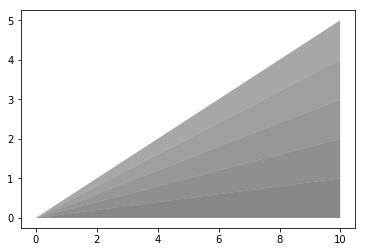

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from math import *

x = np.arange(0,10,0.01)
y=[np.linspace(0, 0, num=x.size)]
color = []
for i in range(5):
    y1 = np.linspace(0, i+1, num=x.size)
    y.append(y1)
    color.append("#"+str((i+1)*10)*3)
    print(color[i])
    plt.fill_between(x,y[i],y[i+1],facecolor=color[i],alpha=0.5)
plt.show()

In [93]:
setting_text = \
"slot machine's settings: \n\
  arm,  chance of hit, color on glaph\n\
    0        0.2        red\n\
    1        0.3        yellow\n\
    2        0.4        green\n\
    3        0.5        blue\n"
print(setting_text)


slot machine's settings: 
  arm,  chance of hit, color on glaph
    0        0.2        red
    1        0.3        yellow
    2        0.4        green
    3        0.5        blue



In [79]:
c = [1, 2, 3, 4]
sum(c)

10

In [116]:
a=[[1,2,3,4],
   [2,3,4,1],
   [3,4,1,2]]
a=np.array(a)
#a.sort(key=lambda x:x[3])
b = a[a[:,-1].argsort()][::-1]
print(b)

[[1 2 3 4]
 [3 4 1 2]
 [2 3 4 1]]


In [126]:
a=[[1,2,3,4],
   [2,3,4,1],
   [3,4,1,2]]
a=np.array(a)
b = np.array([7,8,9,10])
c = np.vstack((b,a,b))
print(c)

[[ 7  8  9 10]
 [ 1  2  3  4]
 [ 2  3  4  1]
 [ 3  4  1  2]
 [ 7  8  9 10]]


In [56]:
a=[1,2,3,4]
a.insert(-1,9)
print(a)

[1, 2, 3, 9, 4]


In [55]:
def aaa(a1, a2=1):
    a1 = a2*2 if a1 is None else a1
    print(a1, a2)

aaa(4)

4 1


In [21]:
np.array(range(0, 10, 1))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [246]:
aa = np.array([1, 2, 3, 4])
bb = np.array([2])
aa/bb

array([ 0.5,  1. ,  1.5,  2. ])

In [268]:
a = [[1]*10]
a.append([1,2,3])
print(a)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 2, 3]]


In [255]:
aaa=[]
aaa.append([]) 
print(aaa*4)

[[], [], [], []]


In [244]:
rt = []
r1 = [1, [1, 2, 3, 4], 0.5]
r2 = [2, [1, 2, 3, 4], 0.5]

rt = r1

rt[0] += r2[0]
print(len(rt[1]))
for i in range(len(rt[1])):
    rt[1][i] += r2[1][i]
rt[2] += r2[2]

print(rt)

ry1 = [rt[0], rt[1][0], rt[2]]
print(ry1)

4
[3, [2, 4, 6, 8], 1.0]
[3, 2, 1.0]


In [39]:
# あとで消す
a = {1:(0,10), 2:(1,20), 3:(0,30), 4:(2,40), 5:(4,10), 6:(3,50), 7:(4,22)}
a.values()
a.keys()

zero_selected = min(list(a.values())[0])
print(zero_selected)

keys_of_zero_selected = [key for key in a if a[key][0] == 0]
print(keys_of_zero_selected)

#for key in a.keys():
#    print(a[key][0])

0
[1, 3]


In [40]:
# あとで消す
max_key = max(a, key=(lambda x:a[x][1]))
max_val = max(a[x][1] for x in a)
#key = [key for key in a if a[key][0]==max_val]

print(max_key, max_val)

6 50


In [111]:
# あとで消す
max_val = max(a.values())
key = [key for key in a if a[key][0] < 2]

print(max_val, key)

(4, 22) [1, 2, 3]


In [221]:
print(a)
for i in a.values():
    print(i[1])

{1: (0, 10), 2: (1, 20), 3: (0, 30), 4: (2, 40), 5: (4, 10), 6: (3, 50), 7: (4, 22)}
10
20
30
40
10
50
22
